# Лабораторная работа №3. Алгоритм Гриффина-Лима

In [1]:
import librosa
import soundfile as sf
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

Ниже определены преобразования <b>Pre-emphasis</b> и <b>De-emphasis</b>, которые применяются для фильтрации исходного и коррекции преобразованного сигналов. Также над стандартным алгоритмом Гриффина-Лима реализована обертка, позволяющая настроить применение фильтра.

In [2]:
# Усиление ВЧ
def pre_emphasis(x, alpha):
    if not (0 < alpha < 1):
        raise ValueError("Parameter alpha should be between 0 and 1")
    return np.append(x[0], x[1:] - alpha * x[:-1])

# Коррекция сигнала в случае использования фильтра, усиливающего ВЧ
def de_emphasis(x, alpha):
    if not (0 < alpha < 1):
        raise ValueError("Parameter alpha should be between 0 and 1")
    return signal.lfilter([1], [1, -alpha], x)

def griffin_lim(D, N, h, i_max):
    _D = D
    for i in range(i_max):
        x_t = librosa.istft(_D, n_fft=N, hop_length=h)
        E = librosa.stft(x_t, n_fft=N, hop_length=h)
        phi = E / np.abs(E)
        _D = D * phi
    
    x_t = librosa.istft(_D, n_fft=N, hop_length=h)
    return x_t.real

# Обертка, учитывающая использование фильтра
def gl_wrapper(x, use_fltr, alpha = 0.96, N=2048, h_ratio=1/4, i_max=64):
    h = int(h_ratio*N)
    raw = x
    if use_fltr:
        x = pre_emphasis(x, alpha)
    
    X = np.abs(librosa.stft(x, n_fft=N, hop_length=h))
    x_ = griffin_lim(X, N, h, i_max)
    
    if use_fltr:
        x_ = de_emphasis(x_, alpha)
    
    spectrum = X
    return x_

def draw_spec(S, sr, h):
    S_db = librosa.amplitude_to_db(np.abs(S))
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_db, y_axis='linear', x_axis='time', sr=sr)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()

## 1 - Загрузка и предобработка аудио

К загруженной записи применен тримминг - удаление отрезков "тишины" в начале и конце сигнала.
Также определены параметры, варьируя которые, можно будет сравнить результаты с исходным сигналом.

- <i>raw</i> - исходный сигнал в последнем преобразовании 
- <i>spectrum</i> - спектрограмма (фильтрованного) сигнала в последнем преобразовании

<i>raw</i> и <i>spectrum</i> - глобальные переменные, которые обновляются при каждом вызове <i>gl_wrapper</i>.

In [3]:
x, fd = librosa.load('Griffin-Lim_rec.wav', sr=22050)
x, _ = librosa.effects.trim(x)

alphas = [0.80, 0.90, 0.96, 0.99]
Ns = [2**i for i in range(9, 13)]
i_maxs = [2**i for i in range(4, 9)]
shifts = [2**i for i in range(-2, 1)]

raw, spectrum = x, librosa.stft(x, n_fft=2048, hop_length=512)

# 2 - Применение алгоритма с параметрами по умолчанию

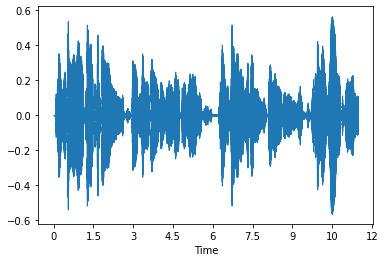

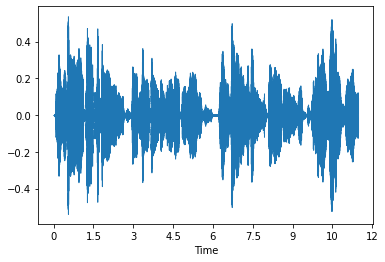

In [4]:
x_ = gl_wrapper(x, True)
sf.write("GL_result.wav", x_, fd)

librosa.display.waveshow(raw, sr=fd)
plt.show()
librosa.display.waveshow(x_, sr=fd)
plt.show()

Спектрограмма сигнала:


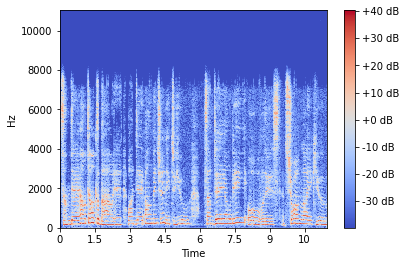

In [5]:
print("Спектрограмма сигнала:")
draw_spec(spectrum, fd, 512)

Сигнал, полученный после применения алгоритма Гриффина-Лима, практически совпадает с исходным.

# 3 - Исследование зависимости качества преобразования от различных параметров

### 1:  Зависимость от коэффициента $\alpha$

In [6]:
x_ = gl_wrapper(x, False)
sf.write("GL_result_alpha_X.wav", x_, fd)

for alpha_ in alphas:
    x_ = gl_wrapper(x, True, alpha=alpha_)
    sf.write("GL_result_alpha_{0}.wav".format(alpha_), x_, fd)

### 2: Зависимость от размерности преобразования Фурье

In [7]:
for N_ in Ns:
    x_ = gl_wrapper(x, True, N=N_)
    sf.write("GL_result_N_{0}.wav".format(N_), x_, fd)

### 3: Зависимость от величины сдвига

In [8]:
for shift in shifts:
    x_ = gl_wrapper(x, True, h_ratio=shift)
    sf.write("GL_result_h_{0}.wav".format(shift), x_, fd)

### 4: Зависимость от количества итераций алгоритма

In [9]:
for i_max_ in i_maxs:
    x_ = gl_wrapper(x, True, i_max=i_max_)
    sf.write("GL_result_imax_{0}.wav".format(i_max_), x_, fd)

# 4 - Итог

При субъективной оценке различий исходного и преобразованного сигналов установлено:

- Самый выраженный эффект наблюдался при изменении сдвига $h$: при его увеличении наблюдался эффект, схожий с тем, который возникает, когда звуковая волна на своем пути сталкивается с переменным препятствием - например, вентилятором;
- Изменение размерности преобразования Фурье $N$ также оказало заметное влияние - при слишком низких значениях возникал звук, похожий на дребезжание тонкой мембраны при воздействии на нее звуковой волны, при высоких же эффект скорее напоминал т.н. "хорус", а оптимальным значением оказалось 2048;
- Значения параметра $\alpha$, близкие к 0.96, оказались оптимальными для фильтра, однако изменение этого параметра не сильно сказалось на субъективном восприятии звука (причиной тому могло стать плохое качество записывающего оборудования);
- Эффект от изменения числа итераций не был заметным, возможно, по той же причине, по которой слабо выражено влияние параметра $\alpha$.